In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

sns.set_context("talk")

## Rendering DRRs

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that X-ray priojection is interoperable as a layer in deep learning frameworks.

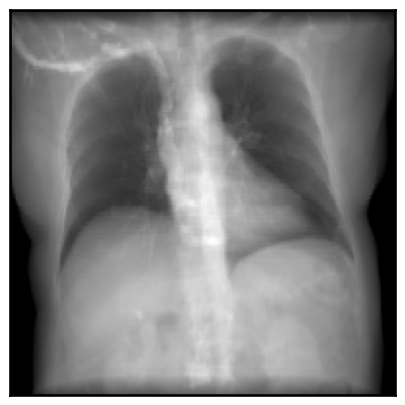

In [ ]:
#| cuda
# Read in the volume and get its origin and spacing in world coordinates
subject = load_example_ct(bone_attenuation_multiplier=1.0)

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
).to(device)

# Specify the C-arm pose with a rotation (yaw, pitch, roll) and orientation (x, y, z)
rot = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 850.0, 0.0]], device=device)
img = drr(rot, xyz, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()

We demonstrate the speed of `DiffDRR` by timing repeated DRR synthesis. Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [ ]:
#| cuda
%timeit drr(rot, xyz, parameterization="euler_angles", convention="ZXY")

29.5 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Rendering multiple DRRs at once

The `rotations` tensor is expected to be of the size `B D`, where `D` is the number of components needed to represent the rotation (e.g., `3` for Euler angles, `4` for quaternions, etc.).
The `translations` tensor expected to be of the size `B D`.

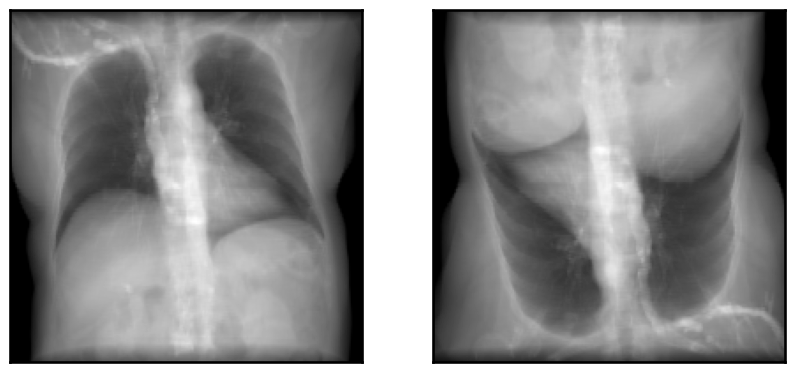

In [ ]:
rot = torch.tensor([[0.0, 0.0, 0.0], [0.0, 0.0, torch.pi]], device=device)
xyz = torch.tensor([[0.0, 850.0, 0.0], [0.0, 850.0, 0.0]], device=device)
img = drr(rot, xyz, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()

Note that rendered DRRs have shape `B C H W` where
- `B` is the number of camera poses passed to the renderer
- `C` is the number of channels in the rendered images
- `H` is the image height, specified in the constructor of the `diffdrr.drr.DRR` object
- `W` is the image width, which defaults to the height if not otherwise specified

Typically, `C = 1`. However, we can have more channels if rendering individual anatomical structures (see the next section).

In [ ]:
img.shape

torch.Size([2, 1, 200, 200])

## Rendering individual structures in separate channels

If the `subject` passed to `diffdrr.drr.DRR` also has a `mask` attribute (a `torchio.LabelMap`), we can use this 3D segmentation map to render individual structures in the DRR.

### Method 1

The first way to do this is to set `mask_to_channels=True` in `DRR.forward`, which will create a new channel for every structure. 

In [ ]:
from diffdrr.pose import convert

# Note that you also have the option to directly pass poses in SE(3) to the renderer
rot = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 850.0, 0.0]], device=device)
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")

img = drr(pose, mask_to_channels=True)

We used [TotalSegmentator v2](https://github.com/wasserth/TotalSegmentator) to automatically segment the example CT. This dataset has 118 classes. Therefore, the output image has `C = 119` (the zero-th channel is a rendering of the background).

In [ ]:
img.shape

torch.Size([1, 119, 200, 200])

We incur a small amount of additional overhead to partition these channels during rendering:

In [ ]:
#| cuda
%timeit drr(pose, mask_to_channels=True)

51.9 ms ± 64.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can also visualize all of these channels superimposed on the DRR. Note that summing over the channel dimension recapitulates the original DRR.

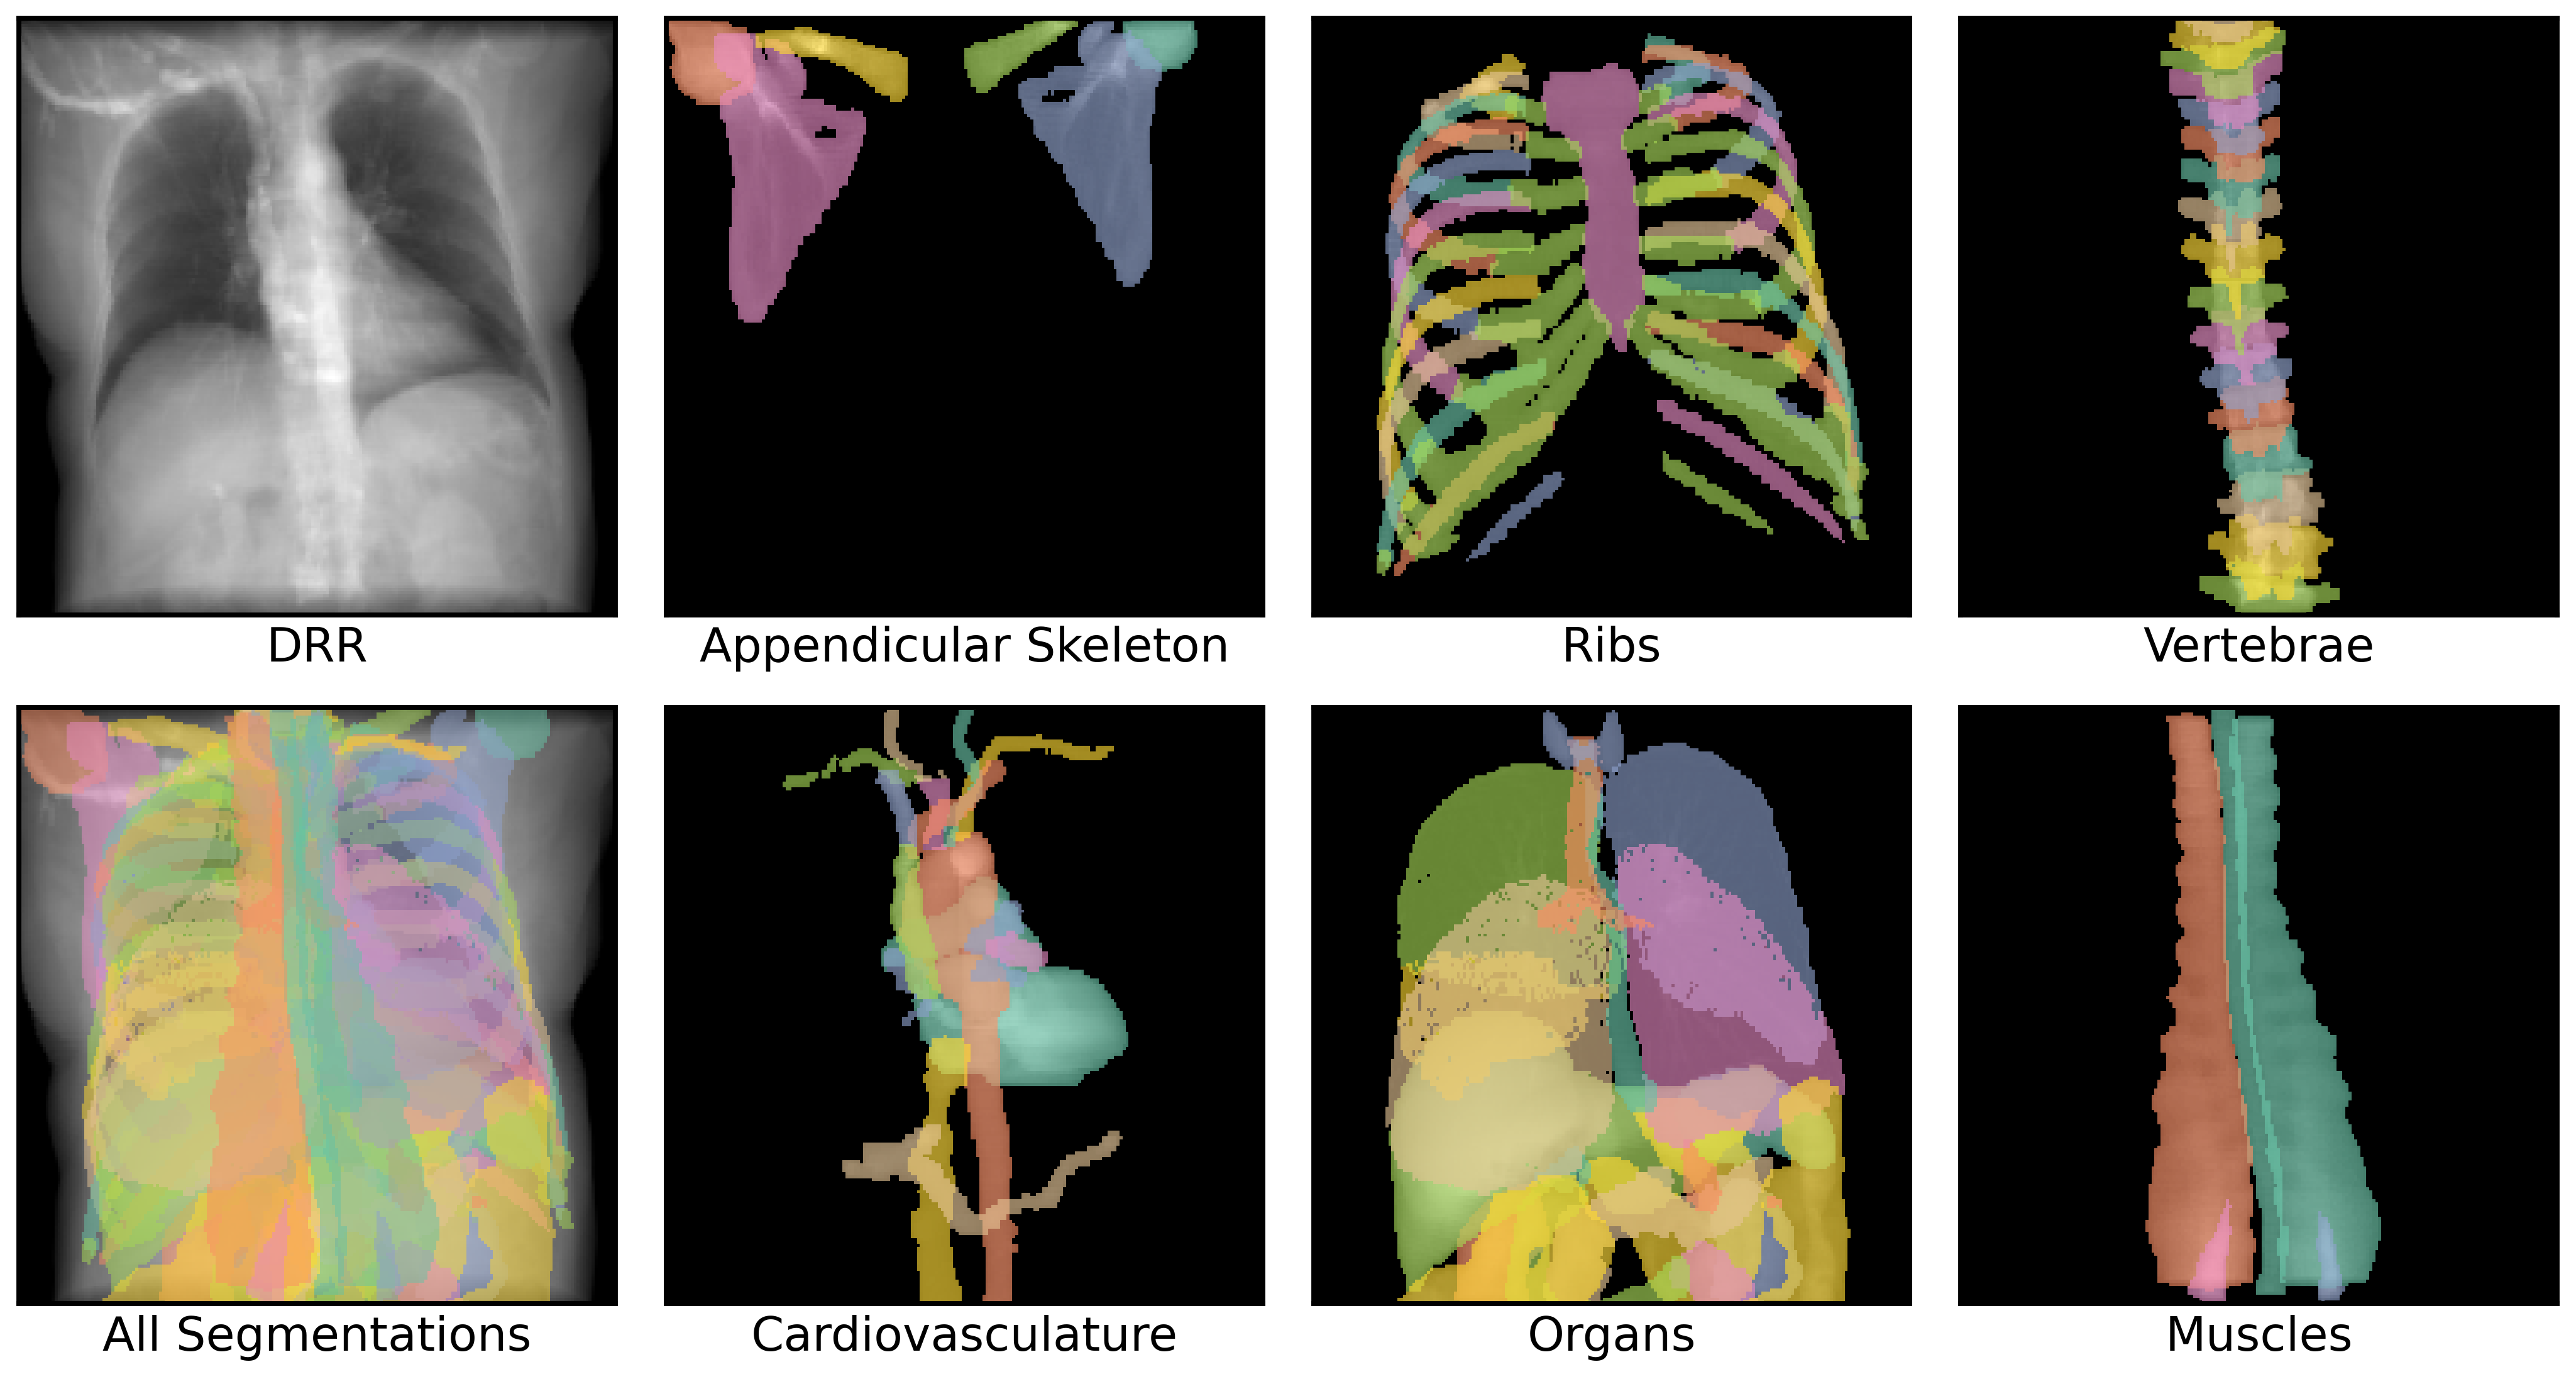

In [ ]:
#| code-fold: true
from diffdrr.visualization import plot_mask

# Relabel classes in the TotalSegmentator dataset
groups = {
    "skeleton": "Appendicular Skeleton",
    "ribs": "Ribs",
    "vertebrae": "Vertebrae",
    "cardiac": "Cardiovasculature",
    "organs": "Organs",
    "muscles": "Muscles",
}

# Plot the segmentation masks
fig, axs = plt.subplots(
    nrows=2,
    ncols=4,
    figsize=(14, 7.75),
    tight_layout=True,
    dpi=300,
)

im = img.sum(dim=1, keepdim=True)
plot_drr(im, axs=axs[0, 0], ticks=False, title="DRR")
plot_drr(im, axs=axs[1, 0], ticks=False, title="All Segmentations")

for (group, title), ax in zip(groups.items(), axs[:, 1:].flatten()):
    jdxs = subject.structures.query(f"group == '{group}'")["id"].tolist()
    im = img[:, jdxs]
    plot_drr(im.sum(dim=1, keepdim=True), title=title, axs=ax, ticks=False)
    masks = plot_mask(im, axs=ax, return_masks=True)
    for jdx in range(masks.shape[1]):
        axs[1, 0].imshow(masks[0, jdx], alpha=0.5)
plt.show()

### Method 2

If we only care about a subset of the structures, we can instead partition the 3D CT prior to rendering. Note that this method is compatible with different rendering backends.

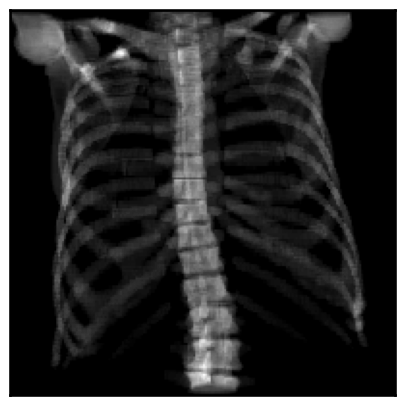

In [ ]:
# Only load the bones in the CT (and the costal cartilage, but it looks weird without it)
structures = ["skeleton", "ribs", "vertebrae"]
labels = subject.structures.query(f"group in {structures}")["id"].tolist()
subject = load_example_ct(labels=labels)
drr = DRR(subject, sdd=1020, height=200, delx=2.0).to(device)

img = drr(pose)
plot_drr(img, ticks=False)
plt.show()

Because we are rendering all structures at once, we don't incur additional overhead.

In [ ]:
#| cuda
%timeit drr(rot, xyz, parameterization="euler_angles", convention="ZXY")

29.6 ms ± 9.66 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Changing the appearance of the rendered DRRs

Following the implementation of DeepDRR, we threshold CTs according to Hounsfield units:

- `air` : HU ≤ -800
- `soft tissue` : -800 < HU ≤ 350
- `bone` : 350 < HU

Increasing the `bone_attenuation_multiplier` upweights the density of voxels thresholded as bone. That is,

- `bone_attenuation_multiplier = 0` completely removes bones
- `bone_attenuation_multiplier > 1` increases the contrast of bones relative to soft tissue
  

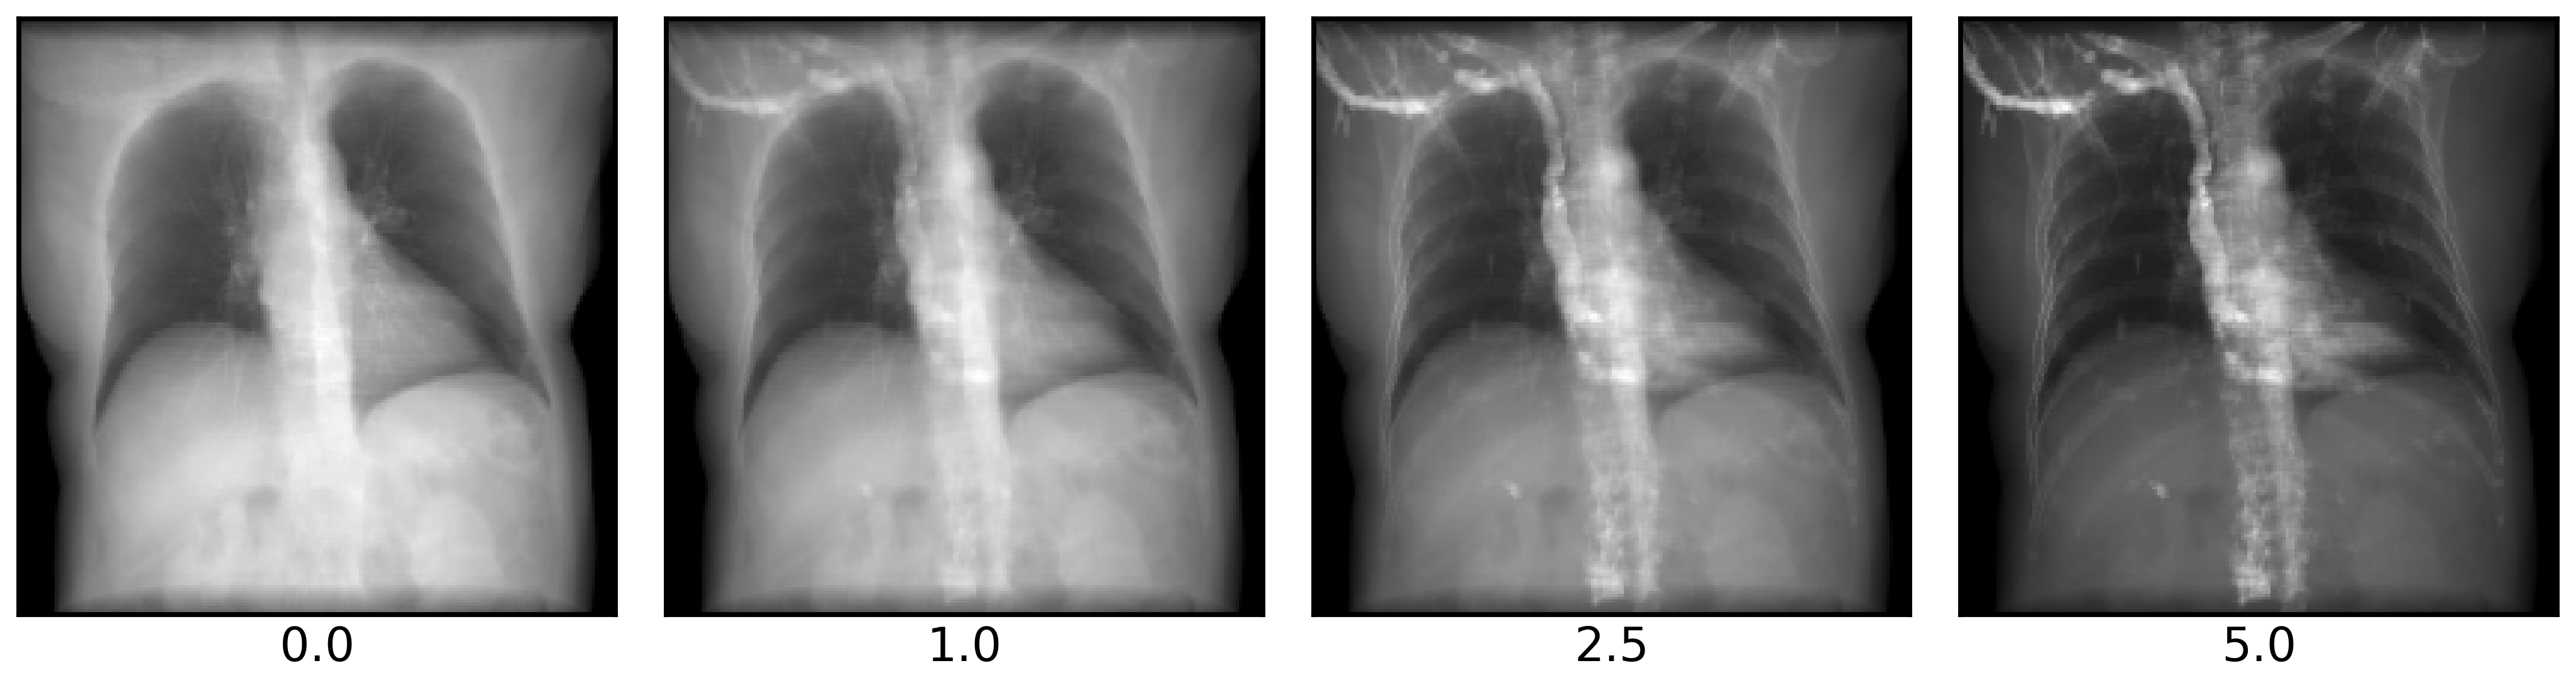

In [ ]:
imgs = []
bone_attenuation_multipliers = [0.0, 1.0, 2.5, 5.0]
for bone_attenuation_multiplier in bone_attenuation_multipliers:
    subject = load_example_ct(bone_attenuation_multiplier=bone_attenuation_multiplier)
    drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device)
    imgs.append(drr(pose))

fig, axs = plt.subplots(1, 4, figsize=(14, 7), dpi=300, tight_layout=True)
plot_drr(torch.concat(imgs), ticks=False, title=bone_attenuation_multipliers, axs=axs)
plt.show()

## Rendering sparse DRRs

You can also render random sparse subsets of the pixels in a DRR.

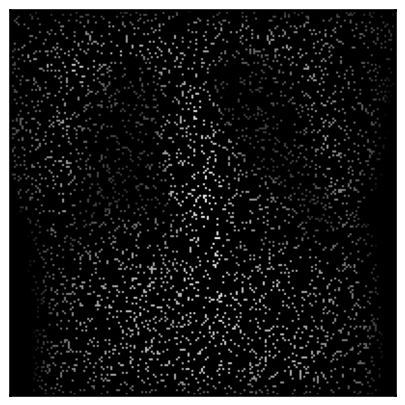

In [ ]:
#| cuda
# Make the DRR with 10% of the pixels
subject = load_example_ct()
drr = DRR(
    subject,
    sdd=1020,
    height=200,
    delx=2.0,
    p_subsample=0.1,  # Set the proportion of pixels that should be rendered
    reshape=True,  # Map rendered pixels back to their location in true space - useful for plotting, but can be disabled if using MSE as a loss function
).to(device)

# Make the DRR
img = drr(pose)
plot_drr(img, ticks=False)
plt.show()

In [ ]:
%timeit drr(pose)

4.8 ms ± 5.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Using different rendering backends

`DiffDRR` can also render synthetic X-rays using trilinear interpolation instead of Siddon's method. The key argument to pay attention to is `n_points`, which controls how many points are sampled along each ray for interpolation. Higher values make more realistic images, at the cost of higher rendering time.

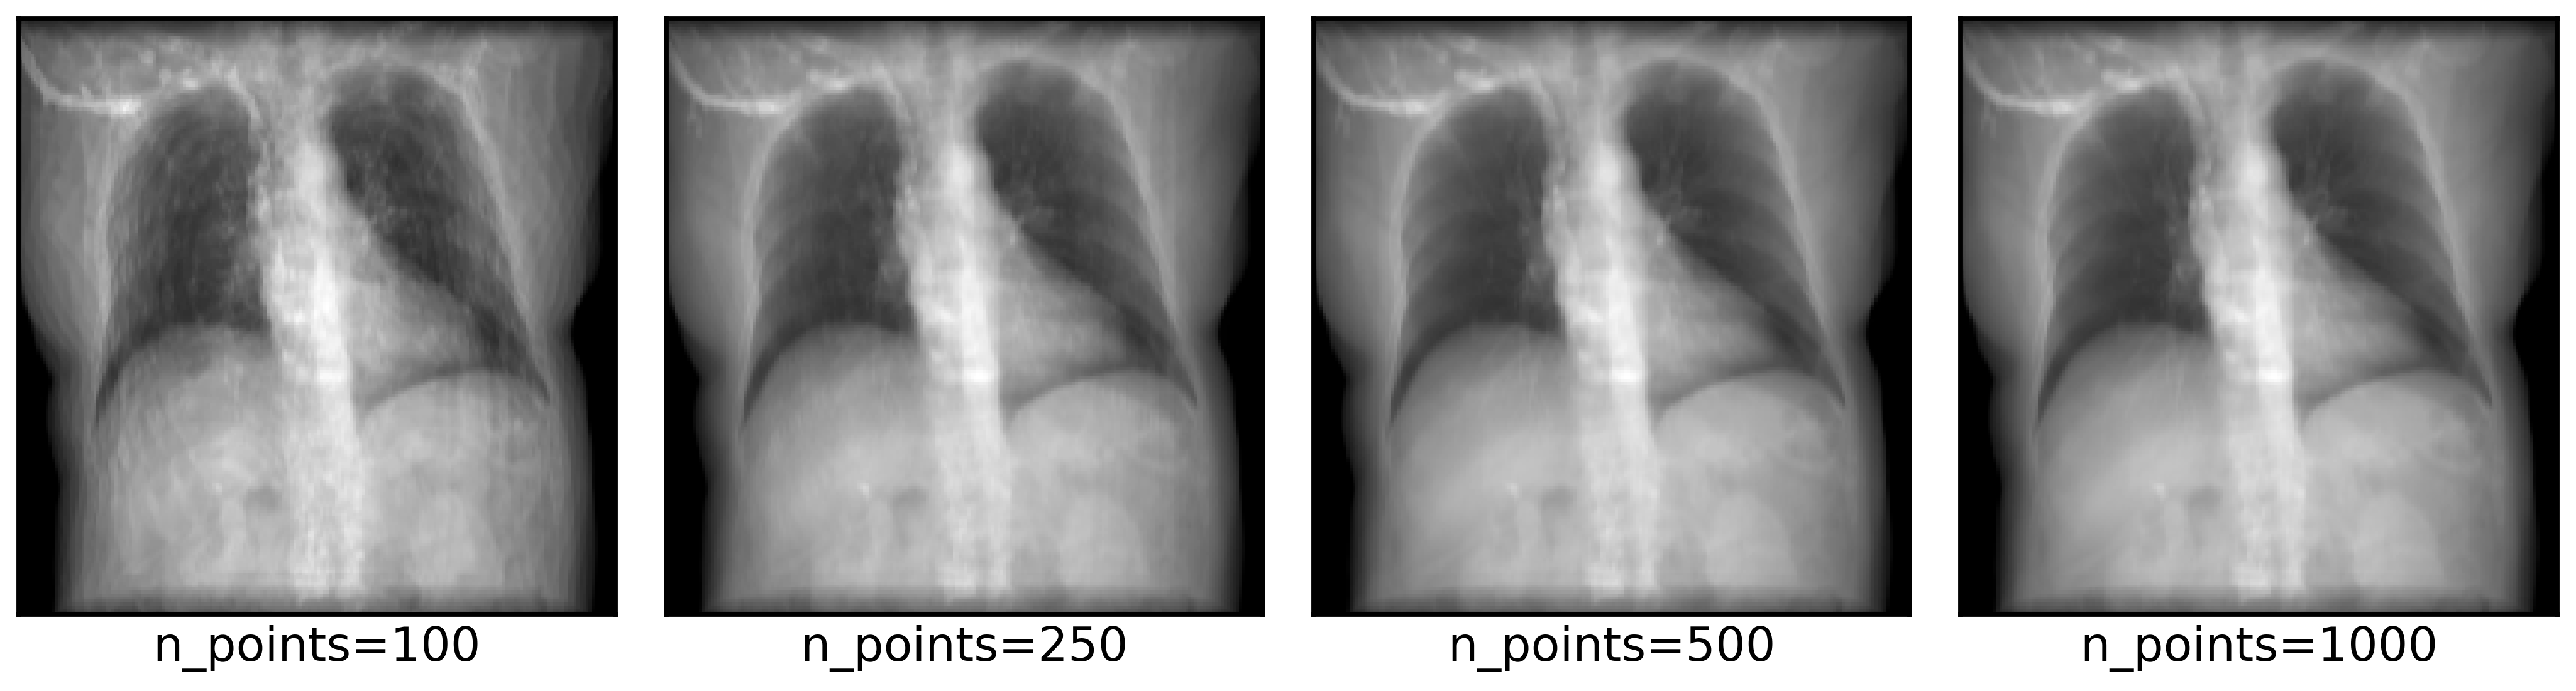

In [ ]:
drr = DRR(
    subject,
    sdd=1020,
    height=200,
    delx=2.0,
    renderer="trilinear",  # Set the rendering backend to trilinear
).to(device)

imgs = []
n_points = [100, 250, 500, 1000]
for n in n_points:
    img = drr(pose, n_points=n)
    imgs.append(img)

fig, axs = plt.subplots(1, 4, figsize=(14, 7), dpi=300, tight_layout=True)
img = torch.concat(imgs)
axs = plot_drr(img, ticks=False, title=[f"n_points={n}" for n in n_points], axs=axs)
plt.show()